# SCC0230 - Inteligência Artificial, Trabalho 1

## Membros

- Giovanni Shibaki Camargo - 11796444
- Pedro Kenzo Muramatsu Carmo - 11796451
- Matheus Giraldi Alvarenga - 12543669
- Rafael Sartori Vantin - 12543353
- Renato Tadeu Theodoro Junior - 11796750
- Vitor da Silveira Paula - 10689651

## Importar bibliotecas necessárias

In [ ]:
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image

## Ler datasets e gerar grafo

Carregamos o primeiro conjunto de dados contendo muitas rotas de voo.

In [ ]:
names = ('airline,airline_id,'
         'source,source_id,'
         'dest,dest_id,'
         'codeshare,stops,equipment').split(',')

routes = pd.read_csv(
    'https://raw.githubusercontent.com/Muramatsu2602/SCC0230-heuristic-search/main/routes.dat',
    names=names,
    header=None)
routes


Carregamos o segundo conjunto de dados com detalhes sobre os aeroportos e mantemos apenas os aeroportos dos Estados Unidos.

In [436]:
names = ('id,name,city,country,iata,icao,lat,lon,'
         'alt,timezone,dst,tz,type,source').split(',')

airports = pd.read_csv(
    'https://raw.githubusercontent.com/Muramatsu2602/SCC0230-heuristic-search/main/airports.dat',
    header=None,
    names=names,
    index_col=4,
    na_values='\\N')
airports_us = airports[airports['country'] ==
                       'United States']
airports_us

,id,name,city,country,icao,lat,lon,alt,timezone,dst,tz,type,source
iata,,,,,,,,,,,,,
BTI,3411,Barter Island LRRS Airport,Barter Island,United States,PABA,70.134003,-143.582001,2,-9.0,A,America/Anchorage,airport,OurAirports
LUR,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,PALU,68.875099,-166.110001,16,-9.0,A,America/Anchorage,airport,OurAirports
PIZ,3414,Point Lay LRRS Airport,Point Lay,United States,PPIZ,69.732903,-163.005005,22,-9.0,A,America/Anchorage,airport,OurAirports
ITO,3415,Hilo International Airport,Hilo,United States,PHTO,19.721399,-155.048004,38,-10.0,N,Pacific/Honolulu,airport,OurAirports
ORL,3416,Orlando Executive Airport,Orlando,United States,KORL,28.545500,-81.332901,113,-5.0,A,America/New_York,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
XMR,11866,Cape Canaveral AFS Skid Strip,Cocoa Beach,United States,KXMR,28.467600,-80.566597,10,NaN,NaN,NaN,airport,OurAirports
NaN,11867,Homey (Area 51) Airport,Groom Lake,United States,KXTA,37.235001,-115.810997,4462,NaN,NaN,NaN,airport,OurAirports
ZZV,11868,Zanesville Municipal Airport,Zanesville,United States,KZZV,39.944401,-81.892097,900,NaN,NaN,NaN,airport,OurAirports


Mantemos todas as rotas de voos nacionais dos Estados Unidos, ou seja, aquelas em que os aeroportos de origem e destino pertencem à lista de aeroportos dos Estados Unidos.

In [437]:
routes_us = routes[
    routes['source'].isin(airports_us.index) &
    routes['dest'].isin(airports_us.index)]
routes_us

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC
...,...,...,...,...,...,...,...,...,...
67565,ZK,2607,SHR,5769,DEN,3751,NaN,0,EM2
67566,ZK,2607,SOW,7078,FMN,3743,NaN,0,BE1
67567,ZK,2607,SOW,7078,PHX,3462,NaN,0,BE1
67569,ZK,2607,VIS,7121,LAX,3484,NaN,0,BE1


Nós construímos a lista de arestas representando nosso grafo, onde os nós são aeroportos, e dois aeroportos estão conectados se existir uma rota entre eles (rede de voos).

In [438]:
edges = routes_us[['source', 'dest']].values
edges

array([['ADQ', 'KLN'],
       ['KLN', 'KYK'],
       ['BRL', 'ORD'],
       ...,
       ['SOW', 'PHX'],
       ['VIS', 'LAX'],
       ['WRL', 'CYS']], dtype=object)

Criamos o grafo NetworkX a partir da matriz de arestas:

In [439]:
g = nx.from_edgelist(edges)
print('Número de nós e arestas:')
print(len(g.nodes()), len(g.edges()))

Número de nós e arestas:
546 2781


Plotando o grafo.

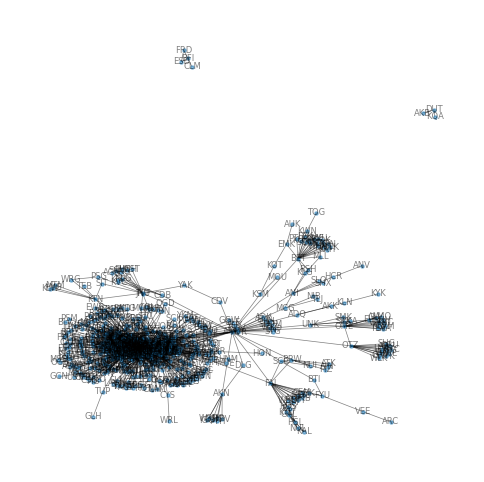

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

Existem alguns aeroportos que não estão conectados ao restante dos aeroportos. Mantemos o maior componente conectado do grafo da seguinte forma (os subgrafos retornados por connected_component_subgraphs() são ordenados por tamanho decrescente).

In [441]:
sg = (g.subgraph(g) for c in nx.connected_components(g))
sg = list(sg)[0]

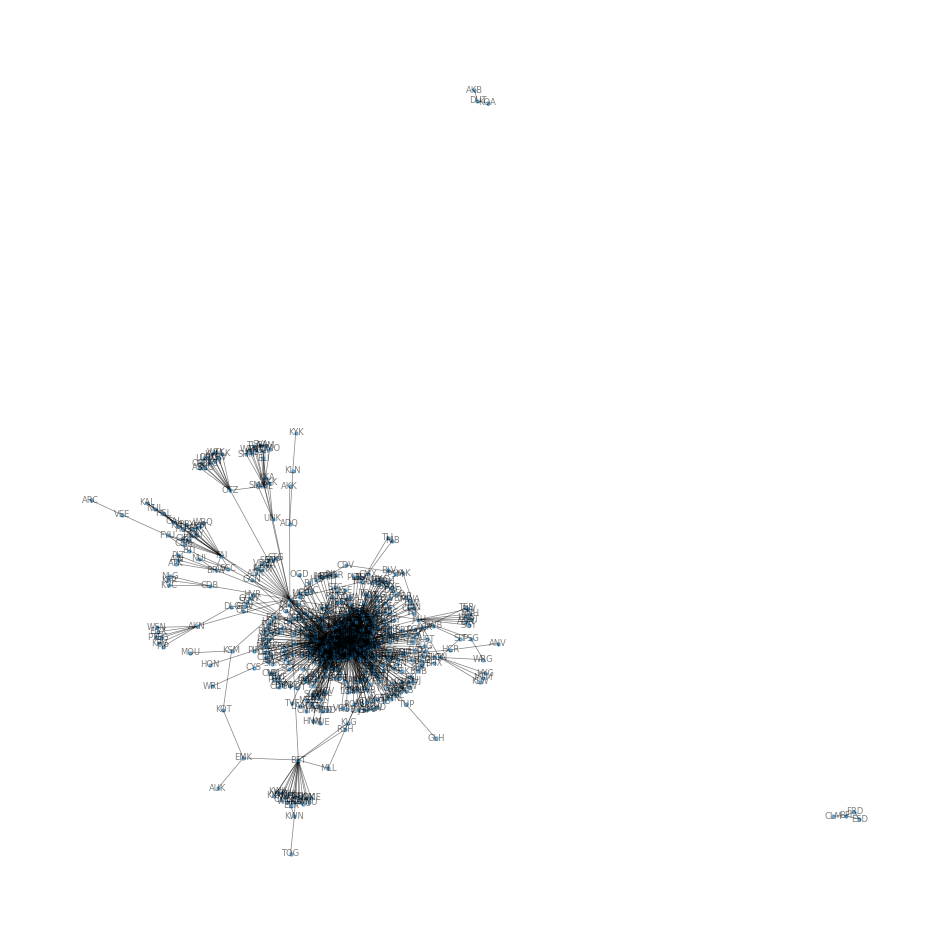

In [442]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [443]:
#sg2 = next(nx.connected_component_subgraphs(g)) 

In [444]:
airports_us.index

Index(['BTI', 'LUR', 'PIZ', 'ITO', 'ORL', 'BTT', 'Z84', 'UTO', 'FYU', 'SVW',
       ...
       'UOX', 'HTV', 'VTN', 'WMC', 'WWR', 'XMR',   nan, 'ZZV', 'ENN', 'WWA'],
      dtype='object', name='iata', length=1435)

In [445]:
air_us = airports_us[~airports_us.index.isna()]
air_us


,id,name,city,country,icao,lat,lon,alt,timezone,dst,tz,type,source
iata,,,,,,,,,,,,,
BTI,3411,Barter Island LRRS Airport,Barter Island,United States,PABA,70.134003,-143.582001,2,-9.0,A,America/Anchorage,airport,OurAirports
LUR,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,PALU,68.875099,-166.110001,16,-9.0,A,America/Anchorage,airport,OurAirports
PIZ,3414,Point Lay LRRS Airport,Point Lay,United States,PPIZ,69.732903,-163.005005,22,-9.0,A,America/Anchorage,airport,OurAirports
ITO,3415,Hilo International Airport,Hilo,United States,PHTO,19.721399,-155.048004,38,-10.0,N,Pacific/Honolulu,airport,OurAirports
ORL,3416,Orlando Executive Airport,Orlando,United States,KORL,28.545500,-81.332901,113,-5.0,A,America/New_York,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WWR,11865,West Woodward Airport,Woodward,United States,KWWR,36.438000,-99.522667,2189,NaN,NaN,NaN,airport,OurAirports
XMR,11866,Cape Canaveral AFS Skid Strip,Cocoa Beach,United States,KXMR,28.467600,-80.566597,10,NaN,NaN,NaN,airport,OurAirports
ZZV,11868,Zanesville Municipal Airport,Zanesville,United States,KZZV,39.944401,-81.892097,900,NaN,NaN,NaN,airport,OurAirports


Vamos desenhar o grafo em um mapa, usando as coordenadas geográficas dos aeroportos. Primeiro, precisamos criar um dicionário onde as chaves são os códigos IATA dos aeroportos e os valores são as coordenadas.

In [446]:
pos = {airport: (v['lon'], v['lat'])
       for airport, v in
       air_us.to_dict('index').items()}

pos

{'BTI': (-143.582000732, 70.1340026855),
 'LUR': (-166.1100006, 68.87509918),
 'PIZ': (-163.0050049, 69.73290253),
 'ITO': (-155.04800415039062, 19.721399307250977),
 'ORL': (-81.332901000977, 28.545499801636),
 'BTT': (-151.529007, 66.91390228),
 'Z84': (-149.119995, 64.301201),
 'UTO': (-153.7039948, 65.99279785),
 'FYU': (-145.25, 66.57150268554688),
 'SVW': (-155.5740051, 61.09740067),
 'FRN': (-149.6529999, 61.26639938),
 'TLJ': (-155.977005005, 62.8944015503),
 'CZF': (-166.0390015, 61.78030014),
 'BED': (-71.28900146, 42.47000122),
 'SNP': (-170.22000122070312, 57.16730117797852),
 'EHM': (-162.06300354, 58.6464004517),
 'STG': (-169.662002563, 56.5783004761),
 'ILI': (-154.9109955, 59.75439835),
 'PTU': (-161.82000732421875, 59.01139831542969),
 'BMX': (-155.259002686, 59.3611984253),
 'OSC': (-83.39409637, 44.45159912),
 'OAR': (-121.762001, 36.68190002),
 'MHR': (-121.2979965, 38.55390167),
 'BYS': (-116.629997253, 35.2804985046),
 'NXP': (-116.1620026, 34.2961998),
 'FSM': (

O tamanho dos nós dependerá do grau dos nós, ou seja, do número de aeroportos conectados a cada nó.

In [447]:
sg.degree()

DegreeView({'ADQ': 3, 'KLN': 2, 'KYK': 1, 'BRL': 2, 'ORD': 149, 'STL': 56, 'DEC': 2, 'JBR': 1, 'KTN': 7, 'MTM': 1, 'ATL': 153, 'LWB': 2, 'MCN': 2, 'MEI': 1, 'MSL': 1, 'PIB': 1, 'TUP': 2, 'EYW': 8, 'FLL': 58, 'RSW': 31, 'TPA': 63, 'MCO': 74, 'GLH': 1, 'GNV': 5, 'JAX': 24, 'PNS': 11, 'TLH': 7, 'PBI': 19, 'LAS': 113, 'LAX': 85, 'MCG': 4, 'NIB': 1, 'TLJ': 1, 'AKP': 2, 'FAI': 18, 'BTT': 3, 'CEM': 2, 'IRC': 2, 'CIK': 2, 'FYU': 4, 'MLY': 1, 'WBQ': 1, 'BET': 22, 'EEK': 2, 'KPN': 3, 'KWN': 3, 'KWT': 1, 'MLL': 2, 'NME': 2, 'WNA': 2, 'CYF': 2, 'KKH': 2, 'KWK': 3, 'OOK': 3, 'PKA': 2, 'PTU': 1, 'ABL': 3, 'OTZ': 13, 'SHG': 3, 'ANC': 34, 'AIN': 2, 'ATK': 2, 'BRW': 7, 'ANI': 7, 'CDV': 2, 'ENA': 1, 'HOM': 1, 'KSM': 3, 'UNK': 5, 'VDZ': 1, 'HCR': 2, 'KLG': 3, 'RSH': 4, 'SHX': 1, 'ANV': 1, 'AUK': 1, 'EMK': 3, 'HPB': 3, 'KUK': 1, 'VAK': 3, 'BKC': 2, 'DRG': 2, 'NUI': 2, 'PIZ': 1, 'BTI': 2, 'SCC': 5, 'ELI': 3, 'KKA': 4, 'OME': 15, 'KOT': 2, 'GAL': 6, 'RBY': 3, 'HSL': 5, 'KAL': 3, 'NUL': 3, 'GAM': 2, 'SVA': 2

In [448]:
deg = dict(sg.degree)
sizes = [5 * deg[iata] for iata in sg.nodes]

Também vamos mostrar a altitude do aeroporto como a cor dos nós.

In [449]:
altitude = air_us['alt']
print(altitude)

iata
BTI       2
LUR      16
PIZ      22
ITO      38
ORL     113
       ... 
WWR    2189
XMR      10
ZZV     900
ENN     362
WWA     354
Name: alt, Length: 1333, dtype: int64


In [450]:
altitude = [altitude[iata] for iata in sg.nodes]

Vamos exibir os rótulos apenas dos maiores aeroportos (aqueles com pelo menos 20 conexões com outros aeroportos dos Estados Unidos).

In [451]:
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in sg.nodes}

Finalmente, usamos o Cartopy para projetar os pontos no mapa.

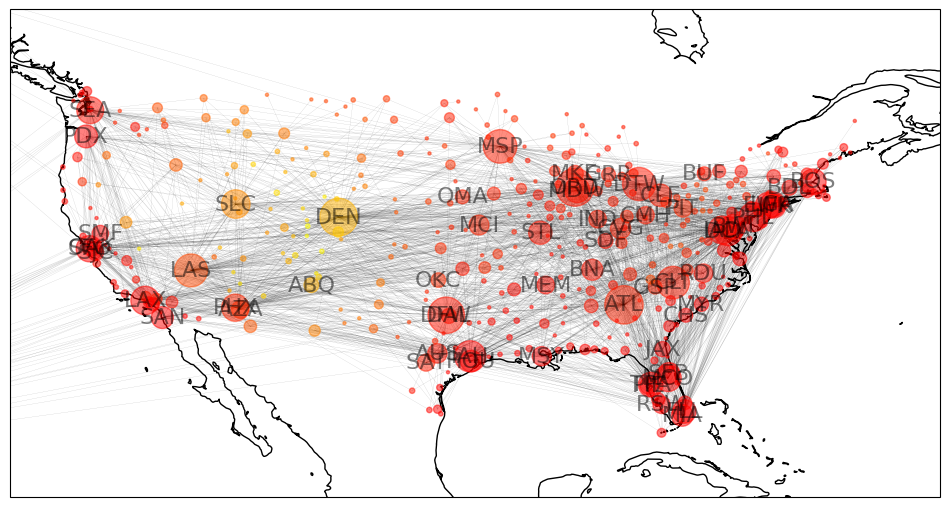

In [452]:
#  Projeção do mapa
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Tamanho do estados unidos continental
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 node_color=altitude,
                 cmap=plt.cm.autumn)

## Aqui vamos calcular a distância usando a latitude e latitude fornecida no DataFrame
Utilizamos a distância euclidiana

In [453]:
df_dist = pd.DataFrame()

for index, row in routes_us[['source','dest']].iterrows():
    source = row['source']
    dest = row['dest']

    source_lat_lon = pos[source]
    dest_lat_lon = pos[dest]

    # Calculate distance between source and destination
    distance = math.sqrt(
        (source_lat_lon[0] - dest_lat_lon[0]) ** 2 +
        (source_lat_lon[1] - dest_lat_lon[1]) ** 2)
    
    df_dist = df_dist.append({
        'distance': distance
    }, ignore_index=True)

C:\Users\giova\AppData\Local\Temp\ipykernel_10236\2321731330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dist = df_dist.append({
C:\Users\giova\AppData\Local\Temp\ipykernel_10236\2321731330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dist = df_dist.append({
C:\Users\giova\AppData\Local\Temp\ipykernel_10236\2321731330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dist = df_dist.append({
C:\Users\giova\AppData\Local\Temp\ipykernel_10236\2321731330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dist = df_dist.append({
C:\Users\giova\AppData\Local\Temp\ipykernel_10236\2321731330.py:15: FutureWarnin

In [454]:
routes_us['distance'] = df_dist['distance']
routes_us.head()

C:\Users\giova\AppData\Local\Temp\ipykernel_10236\573605041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_us['distance'] = df_dist['distance']


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment,distance
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI,2.128521
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI,0.603091
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC,1.153044
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC,1.609324
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC,11.138693


In [461]:
routes_us["from_to"] = routes_us["source"] + "_" + routes_us["dest"] + "_" + routes_us["airline"]

routes_us.to_csv('us_routes_dist.csv')

routes_us.head()

C:\Users\giova\AppData\Local\Temp\ipykernel_10236\4215614579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_us["from_to"] = routes_us["source"] + "_" + routes_us["dest"] + "_" + routes_us["airline"]


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment,distance,from_to
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI,2.128521,ADQ_KLN_2O
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI,0.603091,KLN_KYK_2O
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC,1.153044,BRL_ORD_3E
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC,1.609324,BRL_STL_3E
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC,11.138693,DEC_ORD_3E


### Criar NetworkX Graph do Dataframe

In [573]:
G1 = nx.DiGraph()

for index, airport in airports_us.iterrows():
  G1.add_node(index)

for index, line in routes_us.iterrows():
  if(not pd.isna(line['distance'])):
    G1.add_edge(line['source'], line['dest'], weight=line['distance'])

In [574]:
for from_node, to_node, attributes in G1.edges(data=True):
    weight = attributes.get("weight", None)
    if weight is not None:
        print(f"De {from_node} para {to_node}: Peso = {weight}")


De BTI para FYU: Peso = 8.346113946361992
De BTI para SCC: Peso = 3.0388439102349385
De LUR para OTZ: Peso = 14.189201524932272
De PIZ para BRW: Peso = 24.254692475354517
De BTT para AKP: Peso = 12.34913220458301
De BTT para AET: Peso = 14.059128846798675
De BTT para FAI: Peso = 15.516643863212831
De FYU para CIK: Peso = 20.249658904616407
De FYU para FAI: Peso = 7.967669196791172
De FYU para BTI: Peso = 9.593996840860688
De FYU para VEE: Peso = 41.003088633461665
De TLJ para MCG: Peso = 48.612122815597225
De PTU para BET: Peso = 3.655201172428543
De FSM para DFW: Peso = 14.418919670389817
De FSM para ATL: Peso = 5.914458809010402
De GFK para TVF: Peso = 7.404133013814385
De BOS para ACK: Peso = 29.972827171825607
De BOS para ALB: Peso = 6.526194538903667
De BOS para AUG: Peso = 3.563565724368898
De BOS para BHB: Peso = 3.6554947610601785
De BOS para HYA: Peso = 11.942640514692828
De BOS para LEB: Peso = 13.122662528176887
De BOS para MVY: Peso = 7.808784757629296
De BOS para PVC: Peso

In [591]:
for node in G1.nodes():
    neighbors = list(G1.neighbors(node))
    if (len(neighbors) != 0):
        print(f"Nó {node}: Conexões para {neighbors}")

Nó BTI: Conexões para ['FYU', 'SCC']
Nó LUR: Conexões para ['OTZ']
Nó PIZ: Conexões para ['BRW']
Nó BTT: Conexões para ['AKP', 'AET', 'FAI']
Nó FYU: Conexões para ['CIK', 'FAI', 'BTI', 'VEE']
Nó TLJ: Conexões para ['MCG']
Nó PTU: Conexões para ['BET']
Nó FSM: Conexões para ['DFW', 'ATL']
Nó GFK: Conexões para ['TVF']
Nó BOS: Conexões para ['ACK', 'ALB', 'AUG', 'BHB', 'HYA', 'LEB', 'MVY', 'PVC', 'RKD', 'RUT', 'SLK', 'BUF', 'CLT', 'DCA', 'DFW', 'JFK', 'LAX', 'LGA', 'MDT', 'MIA', 'ORD', 'PDX', 'PHL', 'PHX', 'PIT', 'RIC', 'ROC', 'SAN', 'SEA', 'SYR', 'ATL']
Nó OAK: Conexões para ['HNL', 'KOA', 'LIH', 'OGG', 'PDX', 'PHX', 'SEA']
Nó OMA: Conexões para ['CLT', 'DCA', 'DFW', 'ORD', 'PHX', 'ATL']
Nó OGG: Conexões para ['DFW', 'LAX', 'OAK', 'PHX', 'SJC', 'SMF']
Nó ICT: Conexões para ['DFW', 'ORD', 'ATL']
Nó MCI: Conexões para ['CLT', 'DCA', 'DFW', 'ORD', 'PHL', 'PHX', 'SEA', 'ATL']
Nó MSN: Conexões para ['DFW', 'ORD', 'ATL']
Nó PHX: Conexões para ['ABQ', 'ANC', 'ATL', 'AUS', 'BFL', 'BOI', 'BOS', 

---
## Busca Informada (Heurística): 

Este algoritmo utiliza uma função heurística para priorizar os nós que parecem mais promissores. Ele expande o nó que tem o menor valor heurístico. A implementação é relativamente simples, pois você só precisa de uma fila de prioridade (por exemplo, usando um heap) para gerenciar os nós a serem explorados.

---

## Busca Cega : DFS (Depth-First Search)

DFS (Depth-First Search, ou Busca em Profundidade) é um algoritmo utilizado para percorrer ou buscar em estruturas de dados do tipo grafo. A ideia principal do DFS é explorar tão profundamente quanto possível ao longo de cada ramo antes de retroceder (backtracking).